<h1>Brain Disease Classification Without Data Augmentation</h1>

In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # see issue #152
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1 !!!!
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm

# COVID-19 Data Preparation and Preprocessing

In [2]:
#NOTE: CROPPING BORDER FOR IMAGE, see original code on https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image/55730231#55730231https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image/55730231#55730231
def crop_border(img):
    ## (1) Convert to gray, and threshold]
    th, threshed = cv2.threshold(img, 187, 255, cv2.THRESH_BINARY_INV)

    ## (2) Morph-op to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    ## (3) Find the max-area contour
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    ## (4) Crop and save it
    x,y,w,h = cv2.boundingRect(cnt)
    dst = img[y:y+h, x:x+w]

    return dst

In [3]:
import pandas as pd
noncovid_df = pd.read_csv('./data/fixset.csv')
# all_image_paths = {os.path.basename(x): x for x in  glob(os.path.join('.', 'data', 'images*', '*.png'))}
# print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
# all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# #all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
# all_xray_df.sample(3)

In [4]:
noncovid_df['Image Index'][0]

'00010571_001.png'

data/covid/0NKQ4X.jpg


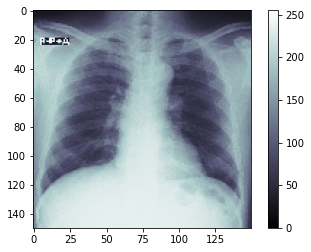

data/covid/0NKQEG.jpg


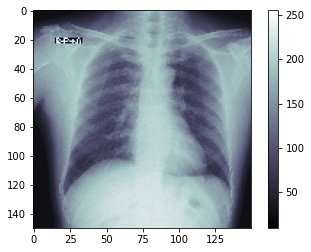

data/covid/0NKQNX.jpg


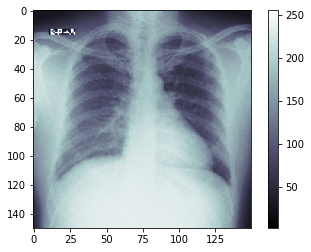

data/images/00010571_001.png
(150, 150)


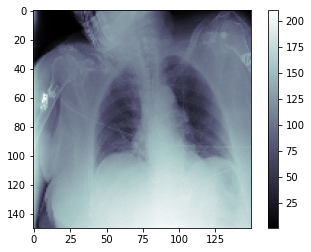

data/images/00011010_019.png
(150, 150)


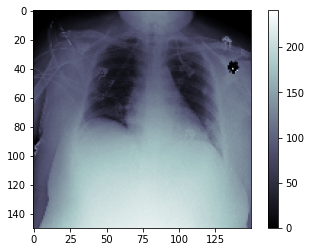

data/images/00016745_001.png
(150, 150)


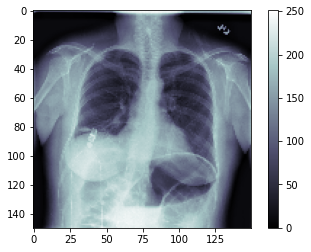

In [5]:
from PIL import Image
# DATADIR = "D:/JCM ELEKTRO ITS/Disertasi/Deep Learning/catanddog/PetImages/"
DATADIR = "data/"
IMG_SIZE = 150
# CATEGORIES = ["Kucing", "Anjing"] # 0 NO TUMOR , 1 LGG , 2 GBM
CATEGORIES = ["covid", "images"] # 0 normal, 1 stroke, tumor 2
num=0
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path)[:3]:  # iterate over each image
        if category is "covid":
            print(path+'/'+img)
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # convert to array
            
            img_array = crop_border(img_array)
            img_array = cv2.bitwise_not(img_array)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_CUBIC)
            # new_array = crop_border(new_array)
            plt.imshow(new_array, cmap=plt.cm.bone)  # graph it
            plt.colorbar()
            plt.show()  # display!
        else:
            img = noncovid_df['Image Index'][num] #image path based on the fix set dataframe
            print(path+'/'+img)
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # convert to array
            img_array = crop_border(img_array)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_CUBIC)
            print(np.shape(new_array))
            plt.imshow(new_array, cmap='bone')  # graph it
            plt.colorbar()
            plt.show()  # display!
            num=num+1

In [6]:
# CREATING TRAINING DATA
training_data = []

def create_training_data():
    num=0

    for category in CATEGORIES:  # do dogs and cats
        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat
        
        for img in tqdm(os.listdir(path)[:noncovid_df.shape[0]]):  # iterate over each image per covid and noncovid
            try:
                if category is "covid":
                    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # convert to array
                    img_array = crop_border(img_array)
                    img_array = cv2.bitwise_not(img_array)
                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_CUBIC)
                else:
                    img = noncovid_df['Image Index'][num]
                    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # convert to array
                    img_array = crop_border(img_array)
                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_CUBIC)
                    num=num+1

                # img_array = cv2.imread(os.path.join(path,img))  # convert to array
                # img_cropped = crop_image(img_array,0)
                # new_array = cv2.resize(img_cropped, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_CUBIC)
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
create_training_data()
print(len(training_data))

100%|██████████| 750/750 [01:25<00:00,  8.79it/s]1263



In [7]:
np.shape(training_data)

(1263, 2)

In [8]:
# Random data because we dont want our predictor to know only just dog and just cat
import random

random.shuffle(training_data)

#CHECKING THAT THE TRAINING DATA IS NOW SHUFFLED
for sample in training_data[:20]:
    print(sample[1])

0
1
1
1
0
1
1
0
1
1
1
0
0
0
1
1
1
0
0
0


In [9]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

# print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
np.shape(X)

(1263, 150, 150, 1)

# Covid Data Augmentation

In [10]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip = False,
                            vertical_flip = False,
                            rotation_range=25,
                            rescale=1/255.0,
                            fill_mode='reflect',
                            shear_range=0.3,
                            zoom_range=0.3)

In [11]:
t1_x, t1_y = next(datagen.flow(X,y, batch_size=1263, shuffle=False))

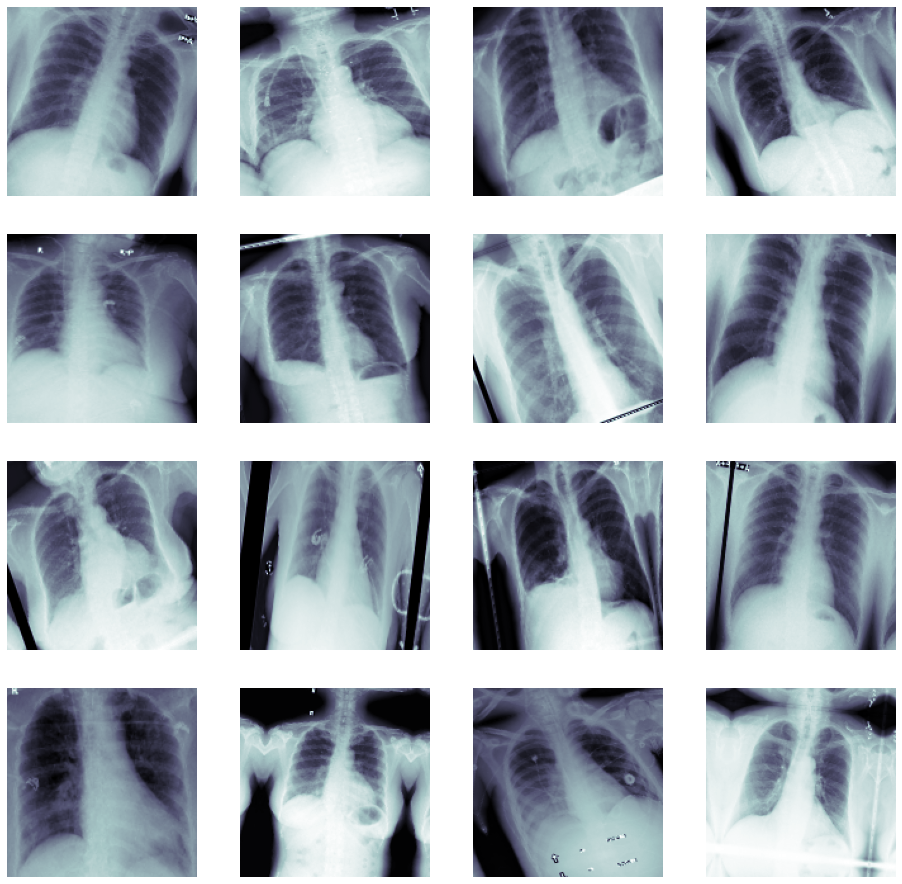

In [12]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t1_x, t1_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    # c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
    #                          if n_score>0.5]))
    c_ax.axis('off')

In [13]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip = False,
                            vertical_flip = False,
                            rotation_range=-20,
                            brightness_range=[0.2,1],
                            rescale=1/255.0,
                            fill_mode='reflect',
                            shear_range=0.1,
                            zoom_range=0.35)

In [14]:
t2_x, t2_y = next(datagen.flow(X,y, batch_size=1263, shuffle=False))

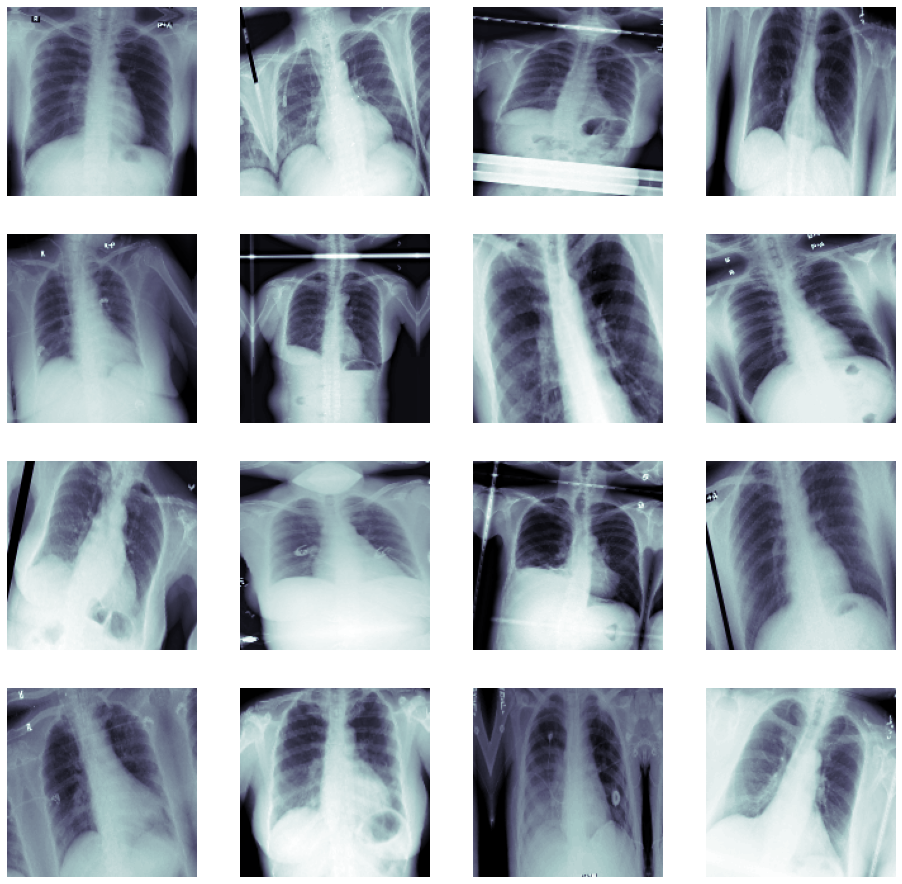

In [15]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t2_x, t2_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    # c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
    #                          if n_score>0.5]))
    c_ax.axis('off')

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip = True,
                            vertical_flip = False,
                            rotation_range=45,
                            brightness_range=[0.2,1],
                            rescale=1/255.0,
                            fill_mode='reflect',
                            shear_range=0.3,
                            zoom_range=0.3)

In [17]:
t3_x, t3_y = next(datagen.flow(X,y, batch_size=1263, shuffle=False))

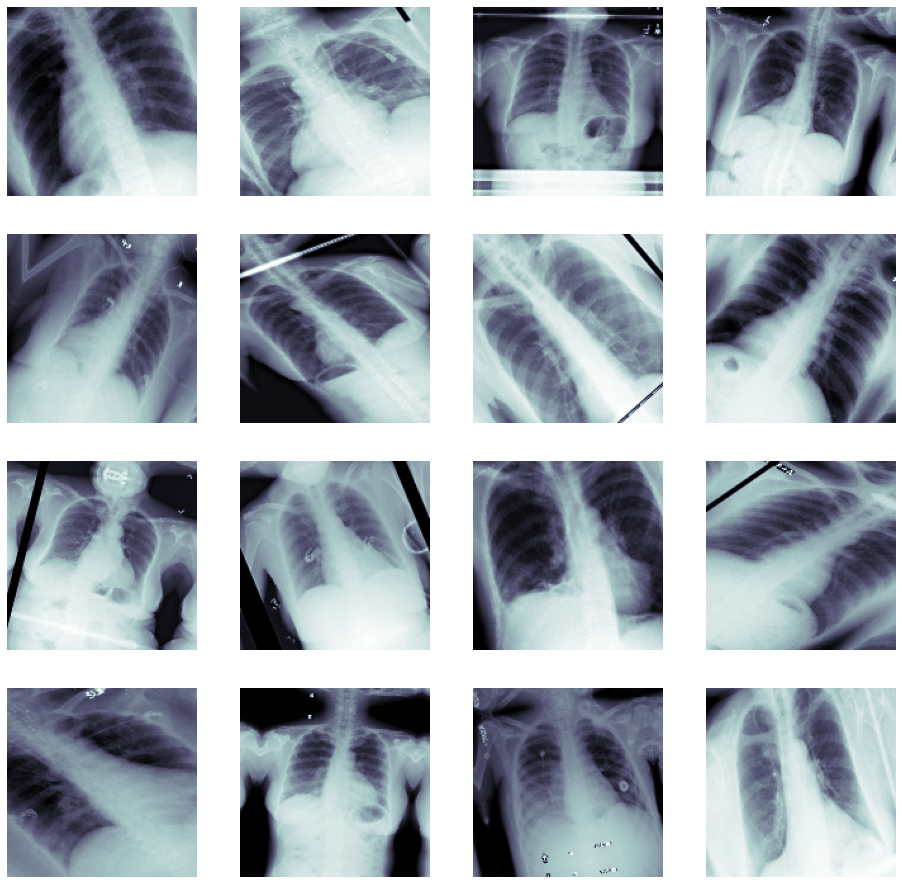

In [18]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t3_x, t3_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    # c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
    #                          if n_score>0.5]))
    c_ax.axis('off')

# Combining COVID-19 Augmented Data

In [19]:
#NOTE: COMBINING TRAINING DATA
covid_data = []

def create_addition_data():
    for slice_num in tqdm(y):
        try:
            image = t1_x[slice_num]
            label = slice_num
            covid_data.append([image, label])  # add this to our addition_data
        except Exception as e:  # in the interest in keeping the output clean...
            pass

    for slice_num in tqdm(y):
        try:
            image = t2_x[slice_num]
            label = slice_num
            covid_data.append([image, label])  # add this to our addition_data
        except Exception as e:  # in the interest in keeping the output clean...
            pass

    for slice_num in tqdm(y):
        try:
            image = t3_x[slice_num]
            label = slice_num
            covid_data.append([image, label])  # add this to our addition_data
        except Exception as e:  # in the interest in keeping the output clean...
            pass

create_addition_data()

100%|██████████| 1263/1263 [00:00<00:00, 632979.56it/s]


In [20]:
np.shape(covid_data)

(3789, 2)

In [21]:
#NOTE: RANDOM data because we dont want our predictor to know only just dog and just cat
import random

random.shuffle(covid_data)

#CHECKING THAT THE TRAINING DATA IS NOW SHUFFLED
for sample in covid_data[:10]:
    print(sample[1])

0
0
1
0
0
1
0
0
1
0


In [22]:
X = []
y = []

for images,label in covid_data:
    X.append(images)
    y.append(label)
print(np.shape(X))
print(np.shape(y))

(3789, 150, 150, 1)
(3789,)


# COVID-19 DATA SPLITTING

In [23]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(t1_x, t1_y, test_size=0.2)
print('train', np.shape(train_X), 'validation', np.shape(test_X))

train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2)
print('train', np.shape(train_X), 'validation', np.shape(valid_X))

train (1010, 150, 150, 1) validation (253, 150, 150, 1)
train (808, 150, 150, 1) validation (202, 150, 150, 1)


# SAVING DATASET TO PICKLE

In [36]:
# save this data, so we don't need to keep calculating it every time we want to play with the nn MODEL
import pickle

pickle_out = open("train_X.pickle","wb")
pickle.dump(train_X, pickle_out)
pickle_out.close()

pickle_out = open("train_Y.pickle","wb")
pickle.dump(train_Y, pickle_out)
pickle_out.close()

pickle_out = open("valid_X.pickle","wb")
pickle.dump(valid_X, pickle_out)
pickle_out.close()

pickle_out = open("valid_Y.pickle","wb")
pickle.dump(valid_Y, pickle_out)
pickle_out.close()

pickle_out = open("test_X.pickle","wb")
pickle.dump(test_X, pickle_out)
pickle_out.close()

pickle_out = open("test_Y.pickle","wb")
pickle.dump(test_Y, pickle_out)
pickle_out.close()

<h1>Load Pickle</h1>

In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # see issue #152
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1 !!!!
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm

In [ ]:
#LOAD PICKLE
import pickle
from keras.utils import to_categorical
pickle_in = open("pickle/fix_first/train_X.pickle","rb")
train_X = pickle.load(pickle_in)
pickle_in = open("pickle/fix_first/train_Y.pickle","rb")
train_Y = pickle.load(pickle_in)

pickle_in = open("pickle/fix_first/valid_X.pickle","rb")
valid_X = pickle.load(pickle_in)
pickle_in = open("pickle/fix_first/valid_Y.pickle","rb")
valid_Y = pickle.load(pickle_in)

pickle_in = open("pickle/fix_first/test_X.pickle","rb")
test_X = pickle.load(pickle_in)
pickle_in = open("pickle/fix_first/test_Y.pickle","rb")
test_Y = pickle.load(pickle_in)

<h1>Building Deep Learning Model using CNN</h1>


In [24]:
from keras.utils import to_categorical

train_Y = to_categorical(train_Y)
valid_Y = to_categorical(valid_Y)
test_Y = to_categorical(test_Y)

In [25]:
train_X = np.array(train_X)
valid_X = np.array(valid_X)
test_X = np.array(test_X)

In [26]:
af_name = "relu"
num_ep = 50

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=train_X.shape[1:]))
model.add(Activation(af_name))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation(af_name))
model.add(MaxPooling2D(pool_size=(3, 3)))


model.add(Conv2D(64, (3, 3)))
model.add(Activation(af_name))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (2, 2)))
model.add(Activation(af_name))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

#tambahan
model.add(Activation(af_name))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

In [ ]:
model.summary()

<h2>Adam Optimizer<h2>

In [27]:
from time import process_time

start = process_time()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_X, 
                    train_Y,
                    epochs = num_ep,
                    batch_size = 32,
                    verbose=1,
                    validation_data=(valid_X,valid_Y))

end = process_time()
time = end - start
print("Elapsed time for model in seconds: ")
print(time)

Epoch 1/50
26/26 [==============================] - 3s 118ms/step - loss: 0.6873 - accuracy: 0.5891 - val_loss: 0.6799 - val_accuracy: 0.5891
Epoch 2/50
26/26 [==============================] - 2s 65ms/step - loss: 0.6616 - accuracy: 0.6052 - val_loss: 0.6145 - val_accuracy: 0.5891
Epoch 3/50
26/26 [==============================] - 2s 66ms/step - loss: 0.5274 - accuracy: 0.6708 - val_loss: 0.4788 - val_accuracy: 0.7574
Epoch 4/50
26/26 [==============================] - 2s 65ms/step - loss: 0.4121 - accuracy: 0.8032 - val_loss: 0.3823 - val_accuracy: 0.8069
Epoch 5/50
26/26 [==============================] - 2s 66ms/step - loss: 0.3453 - accuracy: 0.8515 - val_loss: 0.3607 - val_accuracy: 0.8317
Epoch 6/50
26/26 [==============================] - 2s 67ms/step - loss: 0.3183 - accuracy: 0.8626 - val_loss: 0.3037 - val_accuracy: 0.8663
Epoch 7/50
26/26 [==============================] - 2s 66ms/step - loss: 0.3075 - accuracy: 0.8800 - val_loss: 0.3024 - val_accuracy: 0.8713
Epoch 8/50
2

In [28]:
from datetime import datetime
print(datetime.now().strftime('%Y%m%d-%H%M%S'))

20201018-014818


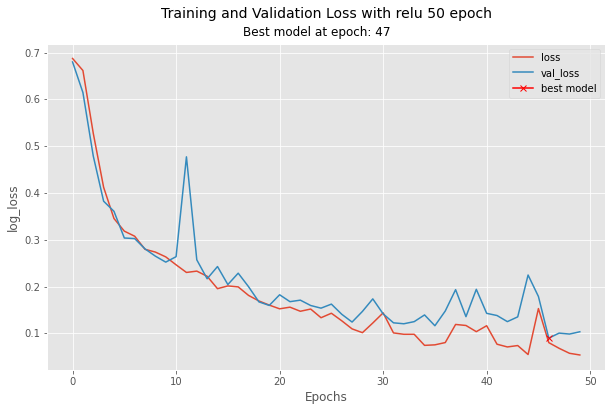

In [29]:
plt.style.use("ggplot") #to add grid
plt.figure(figsize=(10, 6))
plt.suptitle("Best model at epoch: " + str(np.argmin(history.history["val_loss"])+1), y=0.92, fontsize=12)
plt.title("Training and Validation Loss with "+af_name+" "+str(num_ep)+" epoch", y=1.06, fontsize=14)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.savefig("results/" + af_name +"_loss_"+str(num_ep)+"ep"+datetime.now().strftime('%Y%m%d-%H%M%S')+"png")

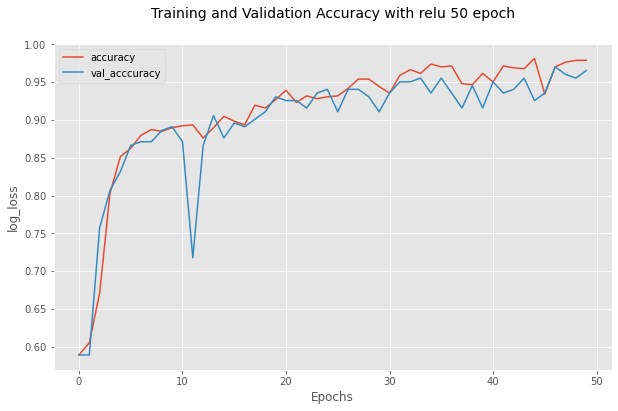

In [30]:
plt.style.use("ggplot") #to add grid
plt.figure(figsize=(10, 6))
# plt.suptitle("Best model at epoch: " + str(np.argmin(res_adam.history["val_loss"])), y=0.92, fontsize=12)
plt.title("Training and Validation Accuracy with "+af_name+" "+str(num_ep)+" epoch", y=1.06, fontsize=14)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_acccuracy")
# plt.plot(np.argmin(res_adam.history["val_loss"]), np.min(res_adam.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.savefig("results/" + af_name +"_acc_"+str(num_ep)+"ep"+datetime.now().strftime('%Y%m%d-%H%M%S')+"png")

In [31]:
y_pred = model.predict(valid_X) #make prediction

from sklearn.metrics import confusion_matrix
import itertools
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.style.use('default')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, y =1.1)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    # TP = cm[0][0] #Actual Positive(abnormal) and Predicted Positive(abnormal)
    # FN = cm[0][1] #Actual Positive and Predicted negative(normal) 
    # TN = cm[1][1] #Actual normal and Predicted normal
    # FP = cm[1][0] #Actual Negative and Predicted positive/abnormal
    TP = cm[1][1] #Actual Positive(abnormal) and Predicted Positive(abnormal)
    FN = cm[1][0] #Actual Positive and Predicted negative(normal) 
    TN = cm[0][0] #Actual normal and Predicted normal
    FP = cm[0][1] #Actual Negative and Predicted positive/abnormal

    Accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    Sensitivity = ((TP)/(TP+FN))*100
    Specitifity = ((TN)/(TN+FP))*100

    Acc = "Accuracy: " + str(round(Accuracy,2)) + "%"
    Sens = "Sensitivity: " + str(round(Sensitivity,2)) + "%"
    Spec = "Specitifity: " + str(round(Specitifity,2)) + "%"
    plt.suptitle(Acc + ", " + Sens+", " + Spec, y=0.85, x=0.55, fontsize=9)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


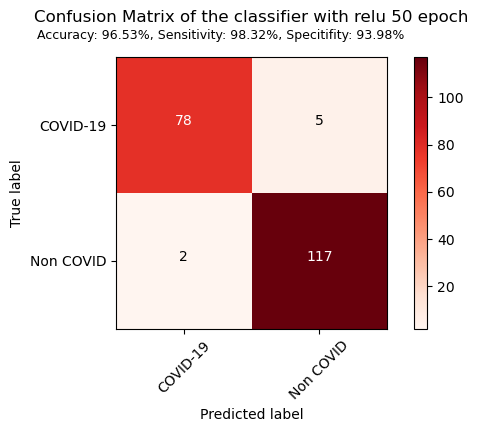

In [32]:
CATEGORIES = ["COVID-19", "Non COVID"]
cm = confusion_matrix(np.argmax(valid_Y, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, CATEGORIES, title="Confusion Matrix of the classifier with "+af_name+" "+str(num_ep)+" epoch")
plt.savefig("results/" + af_name +"_valid_"+str(num_ep)+"ep"+datetime.now().strftime('%Y%m%d-%H%M%S')+".png")

# TESTING DATA

In [34]:
y_pred = model.predict(test_X) #make prediction

from sklearn.metrics import confusion_matrix
import itertools
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.style.use('default')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, y =1.1)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    # TP = cm[0][0] #Actual Positive(abnormal) and Predicted Positive(abnormal)
    # FN = cm[0][1] #Actual Positive and Predicted negative(normal) 
    # TN = cm[1][1] #Actual normal and Predicted normal
    # FP = cm[1][0] #Actual Negative and Predicted positive/abnormal
    TP = cm[1][1] #Actual Positive(abnormal) and Predicted Positive(abnormal)
    FN = cm[1][0] #Actual Positive and Predicted negative(normal) 
    TN = cm[0][0] #Actual normal and Predicted normal
    FP = cm[0][1] #Actual Negative and Predicted positive/abnormal

    Accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    Sensitivity = ((TP)/(TP+FN))*100
    Specitifity = ((TN)/(TN+FP))*100

    Acc = "Accuracy: " + str(round(Accuracy,2)) + "%"
    Sens = "Sensitivity: " + str(round(Sensitivity,2)) + "%"
    Spec = "Specitifity: " + str(round(Specitifity,2)) + "%"
    plt.suptitle(Acc + ", " + Sens+", " + Spec, y=0.85, x=0.55, fontsize=9)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


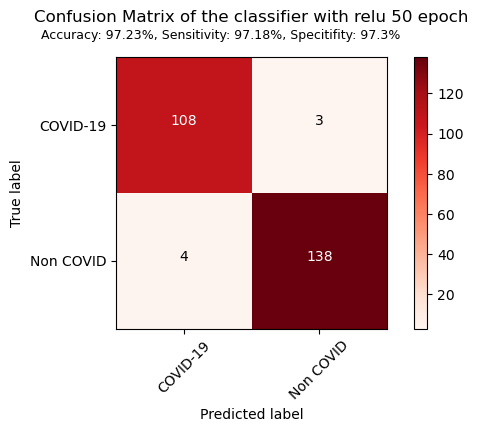

In [35]:
CATEGORIES = ["COVID-19", "Non COVID"]
cm = confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, CATEGORIES, title="Confusion Matrix of the classifier with "+af_name+" "+str(num_ep)+" epoch")
plt.savefig("results/" + af_name +"_testing_"+str(num_ep)+"ep"+datetime.now().strftime('%Y%m%d-%H%M%S')+".png")

In [ ]:
 np.argmax(y_pred, axis=1)

In [ ]:
np.argmax(test_Y, axis=1)

In [ ]:
plt.imshow(x_test[20], cmap=plt.cm.bone)  # graph it
plt.colorbar()
plt.show()  # display!

In [ ]:
TP = cm[0][0] #Actual Positive(abnormal) and Predicted Positive(abnormal)
FN = cm[0][1] #Actual Positive and Predicted negative(normal) 
TN = cm[1][1] #Actual normal and Predicted normal
FP = cm[1][0] #Actual Negative and Predicted positive/abnormal

Accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
Sensitivity = ((TP)/(TP+FN))*100
Specitifity = ((TN)/(TN+FP))*100

print("Accuracy: " + str(round(Accuracy,2)) + " %")
print("Sensitivity: " + str(round(Sensitivity,2)) + " %")
print("Specitifity: " + str(round(Specitifity,2)) + " %")

In [ ]:
from sklearn.metrics import confusion_matrix
plt.style.use("default") #to add grid
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + CATEGORIES)
ax.set_yticklabels([''] + CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()